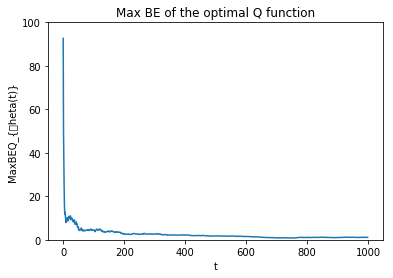

In [142]:

import numpy as np
import random
from numpy.linalg import inv
from numpy.linalg import pinv
# from ChooseAction.ipynb import ChooseAction
import matplotlib.pyplot as plt

#5 room example
#THIS IS THE REWARD MATRIX.. R(s,a); Dimension is S x A = number of states
#x number of actions 

import random

# This function is used to choose a randomized feasible action, given the current state:
def ChooseAction(x,noise):

    r = random.random()
    if x==0:
        if(r<0.5):
            a = 0
        else:
            a = 4
    if x==1:
        if(r<(1/3)):
            a = 1
        elif(r<(2/3)):
            a = 3
        else:
            a = 5;
    if x==2:
        if(r<0.5):
            a = 2;
        else:
            a = 3;
    if x==3:
        if(r<0.25):
            a = 1;
        elif(r<0.5):
            a = 2;
        elif(r<0.75):
            a = 3
        else:
            a = 4     
    if x==4:
        if(r<0.25):
            a = 0
        elif(r<0.5):
            a = 3
        elif(r<0.75):
            a = 4
        else:
            a = 5;
    if x==5:
        if(r<(1/3)):
            a = 1
        elif(r<(2/3)):
            a = 4
        else:
            a = 5    
    
    rr = random.random()
    
    if(rr>noise):

        xtp1 = a
    
    else:
        
        rrr = random.random()

        if x==0:
            if(rrr<0.5):
                xtp1 = 0
            else:
                xtp1 = 4
        if x==1:
            if(rrr<(1/3)):
                xtp1 = 1
            elif(rrr<(2/3)):
                xtp1 = 3
            else:
                xtp1 = 5;
        if x==2:
            if(rrr<0.5):
                xtp1 = 2;
            else:
                xtp1 = 3;
        if x==3:
            if(rrr<0.25):
                xtp1 = 1;
            elif(rrr<0.5):
                xtp1 = 2;
            elif(rrr<0.75):
                xtp1 = 3
            else:
                xtp1 = 4     
        if x==4:
            if(rrr<0.25):
                xtp1 = 0
            elif(rrr<0.5):
                xtp1 = 3
            elif(rrr<0.75):
                xtp1 = 4
            else:
                xtp1 = 5;
        if x==5:
            if(rrr<(1/3)):
                xtp1 = 1
            elif(rrr<(2/3)):
                xtp1 = 4
            else:
                xtp1 = 5
                
    xtp1at = [xtp1,a]            
    return xtp1at
# End of defining the function


# This is the reward function; It is of dimensions X x A = 6 x 6; Its (x,a) entry corresponds to the reward for being in state x and taking action a
R = np.array([[0,-100,-100,-100,-5,-100],[-100,0,-100,-5,-100,100],[-100,-100,0,-5,-100,-100],
             [-100,-5,-5,0,-100,-100],[-5,-100,-100,-5,0,100],[-100,-5,-100,-100,-5,100]])

T = 100000 # Number of iterations for learning (number of data samples we observe)

#This is how often I want to store the data (Bellman error):
t_step = 100 # Every 100 iterations
TVEC2 = range(t_step,T,t_step) # Every 100 iterations
T_small = len(TVEC2) + 1

xt = 4; # start in state 0
beta = 0.8 # Discount factor
rho = 0.85 # Stepsize \gamma_n = (1/n)^\rho
noise = 0.2 # Probability of not going in the direction you want to go; Noisy transitions;

AlenVec = np.array([2,3,2,4,4,3]) # Number of actions in each state; Ex: 2 = number of actions in state 0.

# We need a mapping from state-action pair to a number between 1 and 18; This array is precisely that mapping; E.g. [State 0, Action 0] corresponds to the zeroeth state-action pair, [State 0, Action 4] corresponds to the first state-action pair; 
NumbertoSAPair = np.array([[0, 0],[0,4],[1,1],[1,3],[1,5],[2,2],[2,3],[3,1],[3,2],[3,3],[3,4],[4,0],[4,3],[4,4],[4,5],[5,1],[5,4],[5, 5]])

# Location of the state-action pair indicates the unique number which represents this pair (e.g. [5 5] = 17)

# Inverse mapping: Given state-action pair, what is the curresponding number:
SAPairtoNumber = -1*np.ones((6,6))

for i in range(len(NumbertoSAPair)):
    
    SAPairtoNumber[NumbertoSAPair[i,0],NumbertoSAPair[i,1]]=i
    StaActLen = np.sum(AlenVec); # Total number of state action pairs

# Initialize the Matrix gain for Zap Q:
A_ZapQ = 10*np.eye(StaActLen)

# Initialize the parameter vector for Zap Q:
Qthetat_ZapQ = np.random.rand(StaActLen);

# Initialize the Q function for Zap Q:
Qfun_ZapQ = np.zeros((6,6))

# Storing the Maximal Bellman error after each iteration in this vector:
Qthetat_ZapQ_BEevolQ = np.zeros((T_small))

# Q-learning begins here:

for t in range(T):
    
    # ChooseAction will return the random action chosen in the current state AND the next state
    xtp1at_m = ChooseAction(xt,noise)
    xtp1 = xtp1at_m[0]
    at = xtp1at_m[1]
        
    # Defining the stepsizes:
    alphat = 1./(t+2); # stepsize for parameter recursion
    gammat = np.power((t+1),-rho) # stepsize for matrix gain recursion
        
    num_sa_pair = int(SAPairtoNumber[xt][at]) # Mapping [S A] -> the curresponding number
    
    # Watkins' basis: Column vector with 1 at (x,a) and 0 elsewhere:
    psixtat = np.zeros(StaActLen)
    psixtat[num_sa_pair] = 1; # Basis are indicator functions

    # Watkins' basis evaluated at next state and the optimal policy:
    # Step 1: It takes values 1 at state-action pairs corresponding to xtp1, and all feasible actions
    psixtp1 = np.zeros(StaActLen)
    for jj in range(6):
        if SAPairtoNumber[xtp1,jj]>=0: # Is the action feasible?
            psixtp1[int(SAPairtoNumber[xtp1,jj])] = 1 # Take value 1


    # Zap Q-learning step:
    
    # Q(X_t,A_t):
    Qxt_Zap = np.dot(Qthetat_ZapQ,psixtat)
    
    # Q(X_t+1,a) with all feasible a's; Need to take minimum over all 'a' later:    
    Qxtp1_Zap = np.multiply(Qthetat_ZapQ,psixtp1)

    # Optimal action for state xtp1, given the current parameter estimate:
    OptAct_xtp1 = np.argmax(Qxtp1_Zap)
    # Q-value at xtp1 and the optimal action:
    max_Qxtp1_Zap = np.max(Qxtp1_Zap)
    # max_Qxtp1_Zap = Qxtp1_Zap[OptAct_xtp1]

    # Basis function evaluated at xtp1 and the corresponding optimal action 
    psixtp1_OptAct = np.zeros(StaActLen);
    psixtp1_OptAct[OptAct_xtp1] = 1; 
    
    # Zap Q-learning begins here:

    # Estimating the A(\theta_t) matrix:
    A_ZapQ = A_ZapQ + gammat*( ( - np.outer(psixtat,psixtat) + beta*np.outer(psixtat,psixtp1_OptAct)) - A_ZapQ)
    Ainv_ZapQ = np.linalg.pinv(A_ZapQ)
    
    # Q update for SNR 2 (a) gain:

    Qthetat_ZapQ  =  Qthetat_ZapQ  - alphat*(np.dot(Ainv_ZapQ,psixtat))*((R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap))

    # Zap Q-learning ends here
    
    
    
    xt = xtp1;
    
    # The code from here is to calculate the Bellman error at this iteration
    
    if((t%t_step)==0):
        tt = int(np.floor(t/t_step))

        # Write the Q-function in matrix form (X x A matrix):
        
        for jj in range(StaActLen):
            Qfun_ZapQ[NumbertoSAPair[jj,0],NumbertoSAPair[jj,1]] = Qthetat_ZapQ[jj]

        #Initialize Bellman error to 0:
        BE_Zap = np.zeros(StaActLen)
        
        
        for jj in range(StaActLen):

            x = NumbertoSAPair[jj,0]
            a = NumbertoSAPair[jj,1]

            
            # Calculate E[max_u Q(X_{t+1},u) | X_t=x, A_t = a]:
            max_Qfun_xtp1_Zap = 0;
            NumOfXtp1 = 0;
            for ll in range(StaActLen):
                if(NumbertoSAPair[ll,0] == x):
                    xplus1 = NumbertoSAPair[ll,1]
                    max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap + np.max(Qfun_ZapQ[xplus1])
                    NumOfXtp1 = NumOfXtp1 + 1
            max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap/NumOfXtp1
            
            # BE(x,a) = R(x,a) + beta*E[max_u Q(X_{t+1},u) | X_t=x, A_t = a] - Q(x,a)
            BE_Zap[jj] = R[x,a] + beta*((1-noise)*np.max(Qfun_ZapQ[a]) +  noise*max_Qfun_xtp1_Zap) - Qfun_ZapQ[x,a]

        # MaximalBellmanError = max_{x,a} BE(x,a):  
        Qthetat_ZapQ_BEevolQ[tt] = np.max(abs(BE_Zap))
        
        # End of calculating Bellman Error

        

TVEC1 = range(t_step,T,t_step)
TVEC2 = range(1,T_small)

plt.plot(Qthetat_ZapQ_BEevolQ[TVEC2])
plt.ylim(0,100)
plt.title('SNR 2 \rho = 0.85')
plt.xlabel('t')
plt.ylabel('MaxBEQ_{\theta(t)}')
plt.title('Max BE of the optimal Q function')
plt.show()